In [6]:
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# Modeling library
import lightgbm as lgb
import xgboost as xgb

# Using KFold cross validation
from sklearn.model_selection import KFold

# Encoding categorical features
from sklearn.preprocessing import LabelEncoder

# Memory management
import gc

# Timing utility
from timeit import default_timer as timer

In [7]:
train_data=pd.read_csv('train_MLASM.csv')

In [8]:
train_data.shape

(8000, 1446)

In [9]:
train_data.dtypes.value_counts()

float64    1039
int64       406
object        1
Name: count, dtype: int64

In [10]:
# Below code gives percentage of null in every column
null_percentage = train_data.isnull().sum()/train_data.shape[0]*100

# Below code gives list of columns having more than 60% null
col_to_drop = null_percentage[null_percentage>60].keys()

train_data = train_data.drop(col_to_drop, axis=1)

In [11]:
train_data.shape

(8000, 1446)

In [12]:
train_data.isna().sum().sort_values(ascending=False).head(10)

name         0
minssO       0
minsOH       0
minssssNp    0
minaasN      0
minddsN      0
minsssN      0
minaaN       0
mindsN       0
minsssNHp    0
dtype: int64

In [13]:
# get the columns with null values
null_cols = train_data.columns[train_data.isnull().any()]

# get the count of each data type for columns with null values
dtype_counts = train_data[null_cols].dtypes.value_counts()
dtype_counts

Series([], Name: count, dtype: int64)

In [14]:
# get the mean of the columns with float data type
mean_values = train_data.select_dtypes(include=['float']).mean()

# replace missing values with mean for float columns
train_data[train_data.select_dtypes(include=['float']).columns] = train_data.select_dtypes(include=['float']).fillna(mean_values)

In [15]:
train_data=train_data.drop('name',axis=1)

In [16]:
X=train_data.drop('cls',axis=1)
y=train_data['cls']

In [17]:
from sklearn.feature_selection import VarianceThreshold

# Define the threshold value
threshold_value = 0.70  # Adjust as needed

# Initialize the VarianceThreshold selector
selector = VarianceThreshold(threshold=threshold_value)

# Apply the selector to the original DataFrame
X_selected = selector.fit_transform(X)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the selected feature names
selected_features = X.columns[selected_indices]

# Create the final DataFrame with selected features
X = X[selected_features]

In [18]:
print(X.shape)

(8000, 510)


In [19]:
test_data=pd.read_csv('test_MLASM.csv')

In [20]:
test_data.shape

(2000, 1446)

In [21]:
X_test=test_data.drop('cls',axis=1)
y_test=test_data['cls']

In [22]:
common_columns = X_test.columns.intersection(selected_features)

In [23]:
X_test = X_test[common_columns]

In [24]:
print(X_test.shape)

(2000, 510)


In [25]:
# Create the model with specified hyperparameters
model = lgb.LGBMRegressor(n_estimators=10000,
                          learning_rate = 0.01, 
                          reg_alpha = 0.1, reg_lambda = 0.1, 
                          subsample = 0.9, n_jobs = -1,
                          random_state=1000)

model

LGBMRegressor(learning_rate=0.01, n_estimators=10000, n_jobs=-1,
              random_state=1000, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9)

In [26]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import numpy as np
models = {
    'LightGBM': lgb.LGBMClassifier(force_col_wise=True, n_estimators=100, max_depth=10, num_leaves=50, learning_rate=0.2),
    'XGBoost': xgb.XGBClassifier(learning_rate=0.1, max_depth=3, reg_lambda=0.5, n_estimators=100)
}

[LightGBM] [Info] Number of positive: 4000, number of negative: 4000
[LightGBM] [Info] Total Bins 111236
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 510
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3600, number of negative: 3600
[LightGBM] [Info] Total Bins 110910
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 510
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

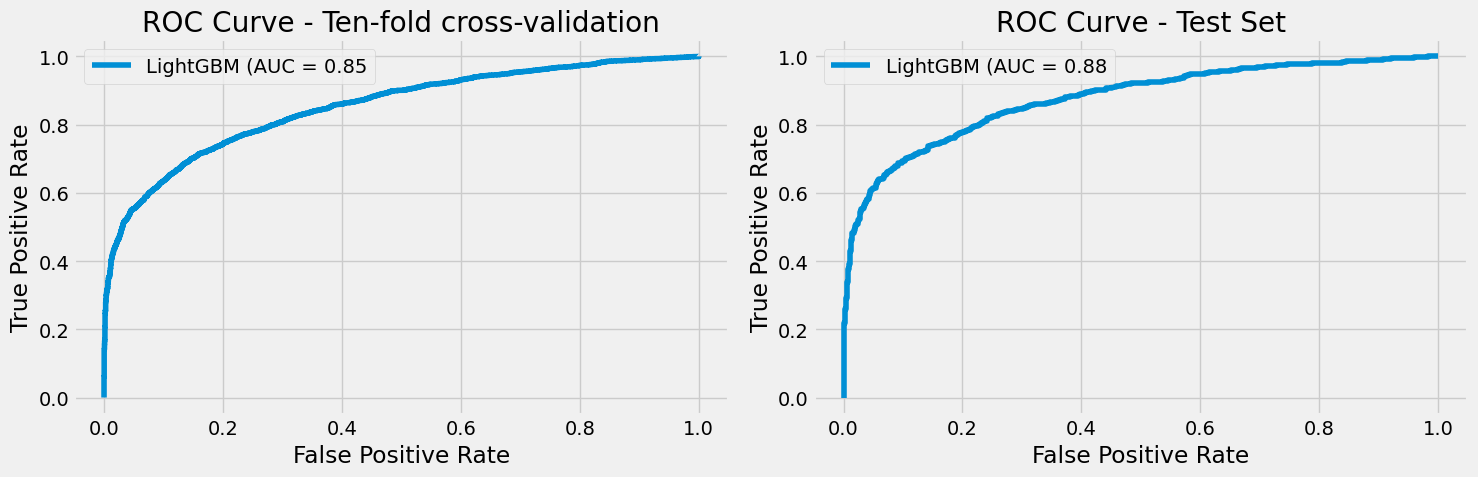

In [32]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_curve, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import numpy as np

models = {'LightGBM': lgb.LGBMClassifier(force_col_wise=True, n_estimators=100, max_depth=10, num_leaves=50, learning_rate=0.2)
}
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Initialize the result dictionaries
train_results = {}
test_results = {}

# Loop through each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X, y)

    # Perform cross-validation and get predicted probabilities for training set
    y_probas_train = cross_val_predict(model, X, y, cv=10, method="predict_proba")[:, 1]

    # Calculate AUC for training set
    fpr_train, tpr_train, _ = roc_curve(y, y_probas_train)
    auc_train = roc_auc_score(y, y_probas_train)

    # Calculate Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y, (y_probas_train > 0.5).astype(int))

    # Calculate Sensitivity and Specificity
    tn, fp, fn, tp = confusion_matrix(y, (y_probas_train > 0.5).astype(int)).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Calculate Accuracy
    accuracy_train = accuracy_score(y, (y_probas_train > 0.5).astype(int))

    train_results[model_name] = {
        'AUC': auc_train,
        'MCC': mcc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Accuracy': accuracy_train
    }

    # Plot ROC curve for training set
    axs[0].plot(fpr_train, tpr_train, label=f'{model_name} (AUC = {auc_train:.2f}')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('ROC Curve - Ten-fold cross-validation')
    axs[0].legend()

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy for the test set
    accuracy_test = accuracy_score(y_test, y_pred)
    test_results[model_name] = {'Test Accuracy': accuracy_test}

    # Predict on the test set
    y_probas_test = model.predict_proba(X_test)[:, 1]

    # Calculate AUC for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_probas_test)
    auc_test = roc_auc_score(y_test, y_probas_test)

    # Calculate Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_test, (y_probas_test > 0.5).astype(int))

    # Calculate Sensitivity and Specificity
    tn, fp, fn, tp = confusion_matrix(y_test, (y_probas_test > 0.5).astype(int)).ravel()
    sensitivity = tp / (tp + fn)


    # Plot ROC curve for test set
    axs[1].plot(fpr_test, tpr_test, label=f'{model_name} (AUC = {auc_test:.2f}')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('ROC Curve - Test Set')
    axs[1].legend()

    test_results[model_name]['AUC'] = auc_test
    test_results[model_name]['MCC'] = mcc
    test_results[model_name]['Sensitivity'] = sensitivity
    test_results[model_name]['Specificity'] = tn / (tn + fp)

    # Print results
    print(f'{model_name} Metrics of Training Set:')
    for metric, value in train_results[model_name].items():
        print(f'{metric}: {value:.4f}')

    print(f'{model_name} Metrics of Test Set:')
    for metric, value in test_results[model_name].items():
        print(f'{metric}: {value:.4f}')

    print('-' * 30)

plt.tight_layout()
plt.show()

